In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as kb
import os
import time
import wandb
import sys
import random as rd
from mpl_toolkits import mplot3d


sys.path.append("..")

from AllMethods import ReversibleSymplecticNN as rs
from AllMethods import PerturbedPendulum_Methods as pp

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [207]:
class R(tf.keras.layers.Layer):

    def __init__(self):
        super(R, self).__init__()
        
    def call(self, inputs):
        return inputs*tf.constant([[-1., -1., -1]])

layer = R()

In [441]:
class RevPINN(tf.keras.Model):
    
    def __init__(self):
        
            super(RevPINN, self).__init__()
        
            self.R = R()
            
            self.A1 = tf.keras.layers.Dense(100, activation='selu')
            self.A2 = tf.keras.layers.Dense(100, activation='selu')
            self.A3 = tf.keras.layers.Dense(100, activation='selu')
            self.A4 = tf.keras.layers.Dense(3, activation='selu')

            
            #self.B1 = tf.keras.layers.Dense(55, activation='tanh')
            #self.B2 = tf.keras.layers.Dense(55, activation='tanh')
            #self.B3 = tf.keras.layers.Dense(2, activation='tanh')
            
            #self.b3 = tf.keras.layers.Dense(55, activation='tanh')
            #self.b2 = tf.keras.layers.Dense(55, activation='tanh')
            #self.b1 = tf.keras.layers.Dense(2, activation='tanh')
            
            self.a4 = tf.keras.layers.Dense(100, activation='selu')
            self.a3 = tf.keras.layers.Dense(100, activation='selu')
            self.a2 = tf.keras.layers.Dense(100, activation='selu')
            self.a1 = tf.keras.layers.Dense(3, activation='selu')
            
    def call(self, input_tensor, training=False):
        
            ###########
            
            xA = self.R(input_tensor)
            
            A = self.A1(xA)
            A = self.A2(A)
            A = self.A3(A)
            A = self.A4(A)

            #B = self.B1(A)
            #B = self.B2(B)
            #B = self.B3(B)
            
            #xB = self.R(B)
            
            xa = self.R(A)

            #b = self.b3(xB)
            #b = self.b2(b)
            #b = self.b1(b)

            a = self.a4(xa)
            a = self.a3(a)
            a = self.a2(a)
            out = self.a1(a)
            
            ############

            #b = self.b3(B)
            #b = self.b2(b)
            #b = self.b1(b)
            
            #out_b = b - xA
            
            ############

            a = self.a4(A)
            a = self.a3(a)
            a = self.a2(a)
            a = self.a1(a)
            
            out_a = a - xA
            
            return out, out_a #, out_b

In [442]:
model = RevPINN()

In [486]:
file = open("x_train.txt", "r")
line_count = 0
for line in file:
    if line != "\n":
        line_count += 1
file.close()

x = []
y = []

read_x = open("x_train.txt", "r")
read_y = open("y_train.txt", "r")
read_z = open("z_train.txt", "r")

for i in range(line_count):

    x.append([float(read_x.readline()), float(read_y.readline()), float(read_z.readline())])

read_x.close()
read_y.close()
read_z.close()

print("Number of points: ", len(x))

Number of points:  100005


In [487]:
x_train = x[0:-1]
y_train = x[1:]

In [488]:
np.amin(tf.math.squared_difference(x_train, y_train).numpy())

2.4016344e-12

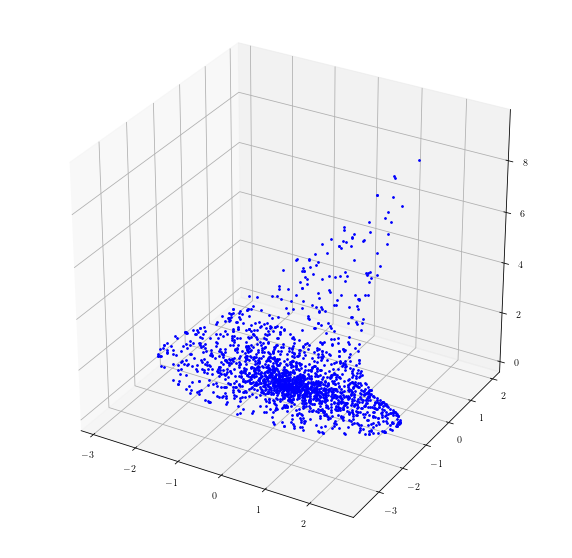

In [446]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection ="3d")
for i,j,k in x_train[-10000:]:
    ax.scatter(i, j, k, color = 'b', s=3)
plt.savefig("strange_attractor")
plt.show()

In [489]:
#train_batch = 30000

x_train = np.array(x_train)
x_train = x_train.astype(np.float32)

y_train = np.array(y_train)
y_train = y_train.astype(np.float32)

a = np.zeros(np.shape(x_train))

a_train = np.array(a)
a_train = a_train.astype(np.float32)

In [490]:
# DECAYING LEARNING RATE
def scheduler(epoch, lr):
    if epoch < 5:
        print(lr)
        return lr
    else:
        return lr*tf.math.exp(-0.001)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [491]:
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    loss_weights = [1., 2.],
    #loss = custom_loss,
    #optimizer=tfps.optimizers.bfgs_minimize(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    optimizer=keras.optimizers.Adam(0.01), #, clipvalue = 0.001),
    #metrics=["accuracy"],
)

In [492]:
history = model.fit(x_train, [y_train, a_train], batch_size = 100000, callbacks=[callback], epochs = 500,  verbose=0) #np.array(x), [np.array(y),a,a]

0.009999999776482582
0.009999999776482582
0.009999999776482582
0.009999999776482582
0.009999999776482582


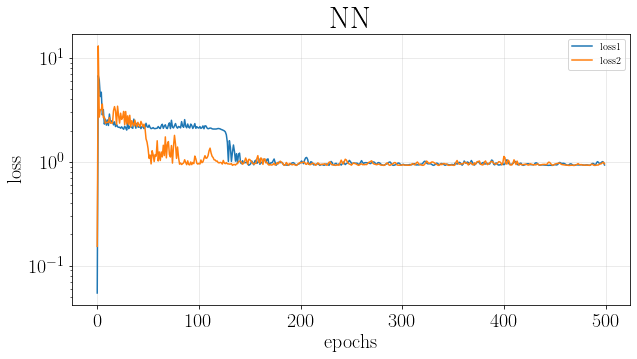

In [493]:
plt.figure(figsize = (10,5))
plt.plot(history.history["output_1_loss"], label="loss1")
plt.plot(history.history["output_2_loss"], label="loss2")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'NN', fontsize = 30)
plt.xlabel(r'epochs', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=10)
plt.grid(axis='both', alpha=.3)
#plt.savefig("loss_Henon_E01667")

In [479]:
tf.reduce_mean(tf.math.squared_difference(model(x_train)[0], y_train))

<tf.Tensor: shape=(), dtype=float32, numpy=0.05189664>

In [482]:
tf.math.squared_difference(model(x_train)[0], y_train)

<tf.Tensor: shape=(20000, 3), dtype=float32, numpy=
array([[0.00294957, 0.00457815, 0.00035048],
       [0.00103351, 0.00510793, 0.00225741],
       [0.00088017, 0.00014808, 0.01352402],
       ...,
       [0.00051271, 0.01587855, 0.00289057],
       [0.00804478, 0.00531913, 0.02836416],
       [0.01291776, 0.00651291, 0.04757851]], dtype=float32)>

In [484]:
y_train

array([[ 0.42474532, -0.22369653,  1.8548484 ],
       [ 0.5908867 , -0.637442  ,  1.2879666 ],
       [ 0.6850949 , -0.96005774,  0.8068036 ],
       ...,
       [-1.2014929 , -0.39154392,  1.0281786 ],
       [-0.76619595,  0.08159614,  0.91690874],
       [-0.15243682,  0.3144108 ,  1.1708301 ]], dtype=float32)

In [485]:
model(x_train)

(<tf.Tensor: shape=(20000, 3), dtype=float32, numpy=
 array([[ 0.37043536, -0.2913586 ,  1.8735696 ],
        [ 0.55873847, -0.7089118 ,  1.3354788 ],
        [ 0.65542716, -0.97222656,  0.69051075],
        ...,
        [-1.1788497 , -0.2655338 ,  0.9744145 ],
        [-0.85588866,  0.15452848,  0.7484921 ],
        [-0.03878049,  0.39511344,  0.95270514]], dtype=float32)>,
 <tf.Tensor: shape=(20000, 3), dtype=float32, numpy=
 array([[-0.09318435,  0.20743504,  0.28563333],
        [-0.15546387,  0.08482686,  0.16244519],
        [-0.11969978,  0.10321212, -0.171556  ],
        ...,
        [ 0.02030265, -0.05523467,  0.22115004],
        [-0.04954898,  0.01630697, -0.039873  ],
        [-0.04497248, -0.09325887,  0.04920942]], dtype=float32)>)